In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import importlib
warnings.filterwarnings('ignore')

In [2]:
sd = "2018-01-01"
ed = "2024-01-01"


snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
data_tab = pd.read_html(snp500url)

tickers = data_tab[0][1:]['Symbol'].tolist()


raw = yf.download(tickers=tickers, start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  502 of 502 completed

8 Failed downloads:
['CMI']: ConnectionError(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))
['GEV', 'SOLV', 'SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1704085200")')
['FSLR']: ChunkedEncodingError(ProtocolError('Connection broken: IncompleteRead(1 bytes read, 1 more expected)', IncompleteRead(1 bytes read, 1 more expected)))
['BF.B', 'ETN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [3]:
dataset = pd.DataFrame(raw)
missing_frac = dataset.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_frac[missing_frac > 0.2].index))
dataset.drop(columns=drop_list, axis = 1, inplace=True)
dataset.bfill(axis='index', inplace=True)
print('\nNull values:', dataset.isnull().values.any())
print('NaN values:', dataset.isna().values.any())


Null values: False
NaN values: False


In [4]:
from sklearn.preprocessing import StandardScaler
returns = dataset.pct_change().dropna()
returns = pd.DataFrame(returns).reset_index().drop(columns="Date")
scaler = StandardScaler()
normalized_returns = pd.DataFrame(scaler.fit_transform(returns), columns=returns.columns, index=returns.index)

R = normalized_returns.corr().reset_index()

In [5]:

import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px


G = nx.Graph()
G.add_nodes_from(dataset.columns)
threshold = 0.5
for i in range(len(dataset.columns)):
    for j in range(i + 1, len(dataset.columns)):
        corr = R.iloc[i, j]
        if abs(corr) > threshold:
            G.add_edge(dataset.columns[i], dataset.columns[j], weight=corr)

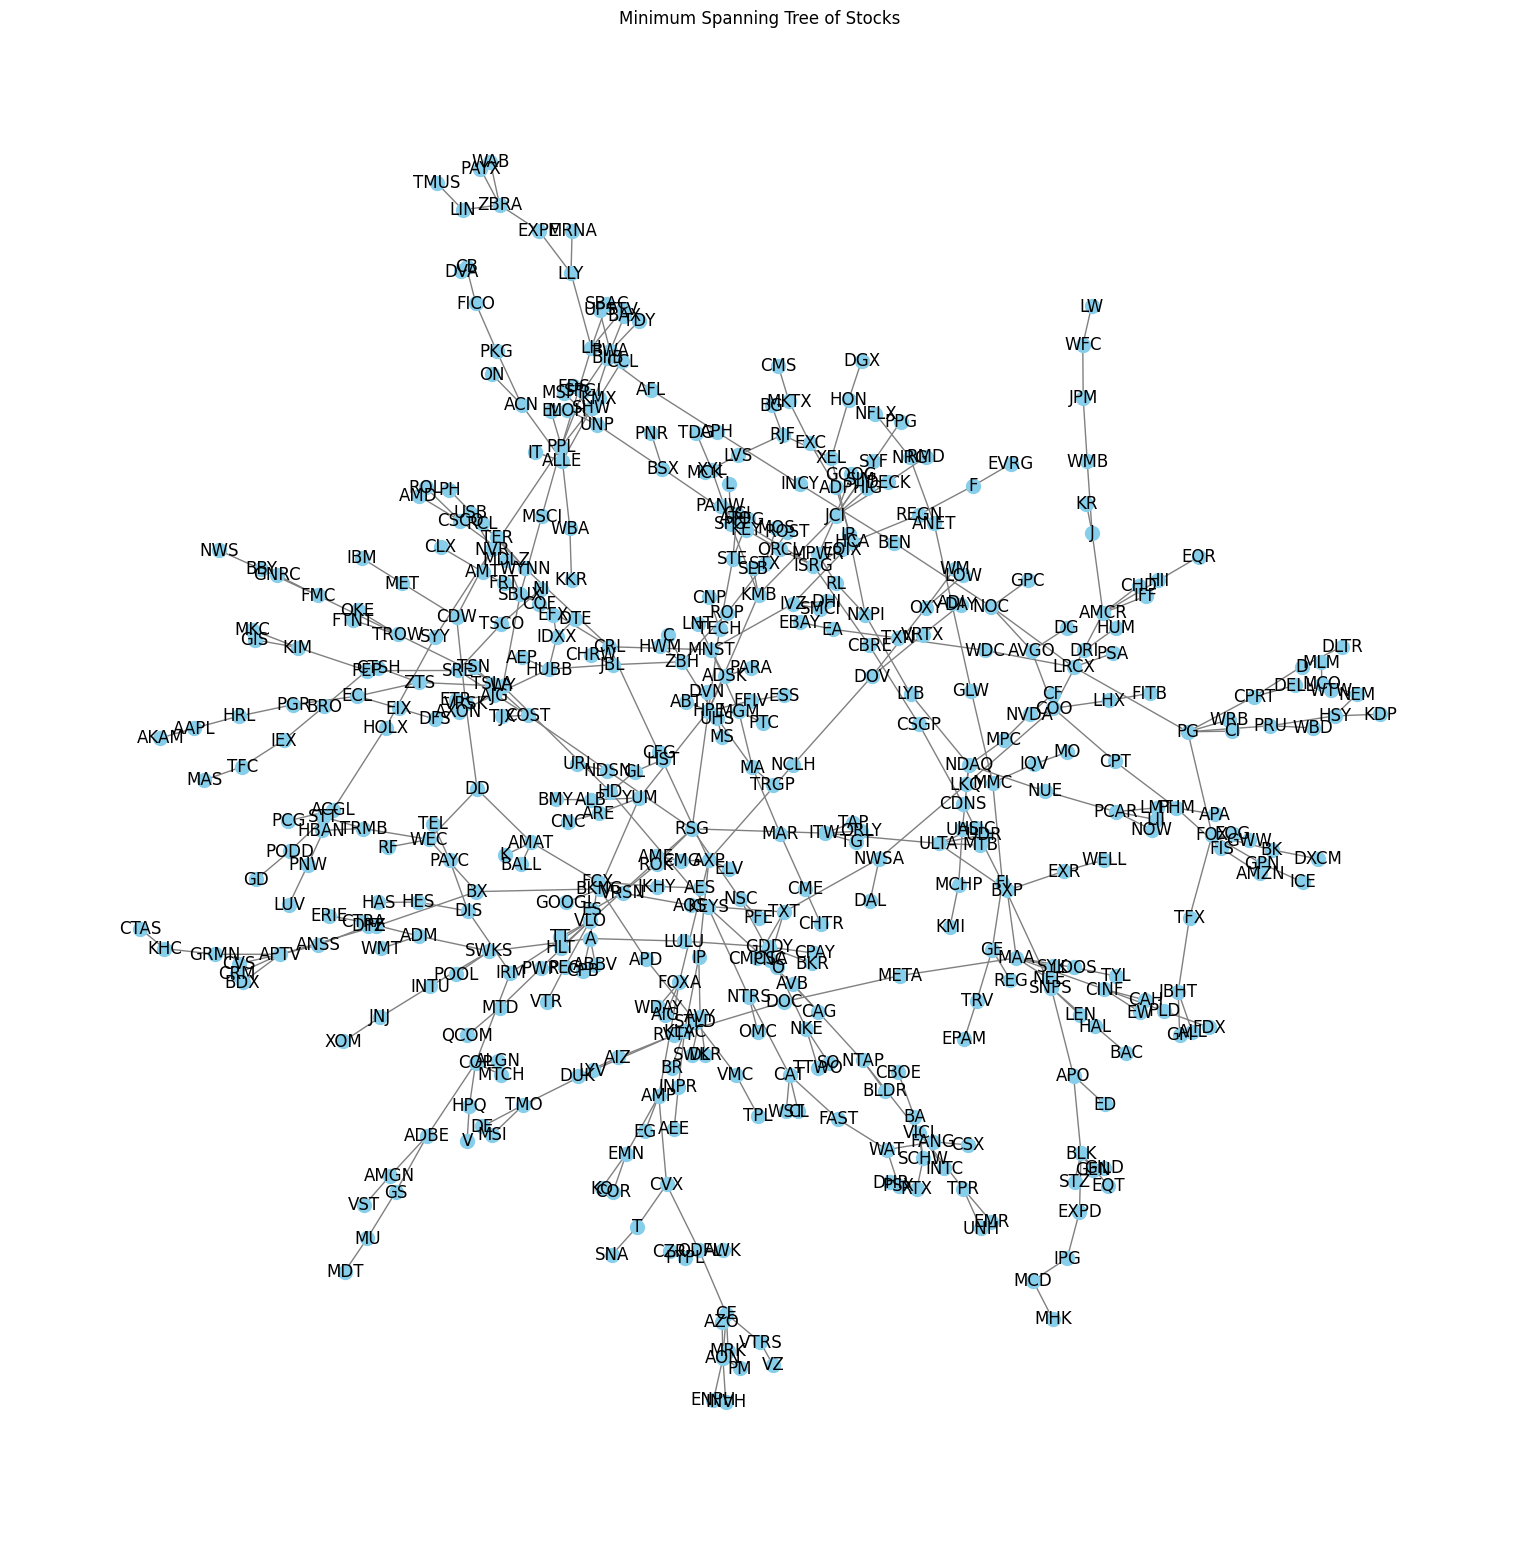

In [11]:
mst = nx.minimum_spanning_tree(G)

# Plot MST
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(mst)
nx.draw(mst, pos, with_labels=True, node_size=100, node_color="skyblue", edge_color="gray")
plt.title("Minimum Spanning Tree of Stocks")
plt.show()

In [12]:
benchmark_data = yf.download("SPY", start=sd, end=ed, auto_adjust=True)['Close']
benchmark_returns = benchmark_data.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [24]:
results = pd.DataFrame(columns=['Method', 'Max_d', 'Silhouette Score', 'Cophenetic Correlation', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])

# Clustering evaluation
methods = ['single', 'complete', 'average', 'centroid', 'ward', 'median']
max_d_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.1, 1.3, 1.5, 2]

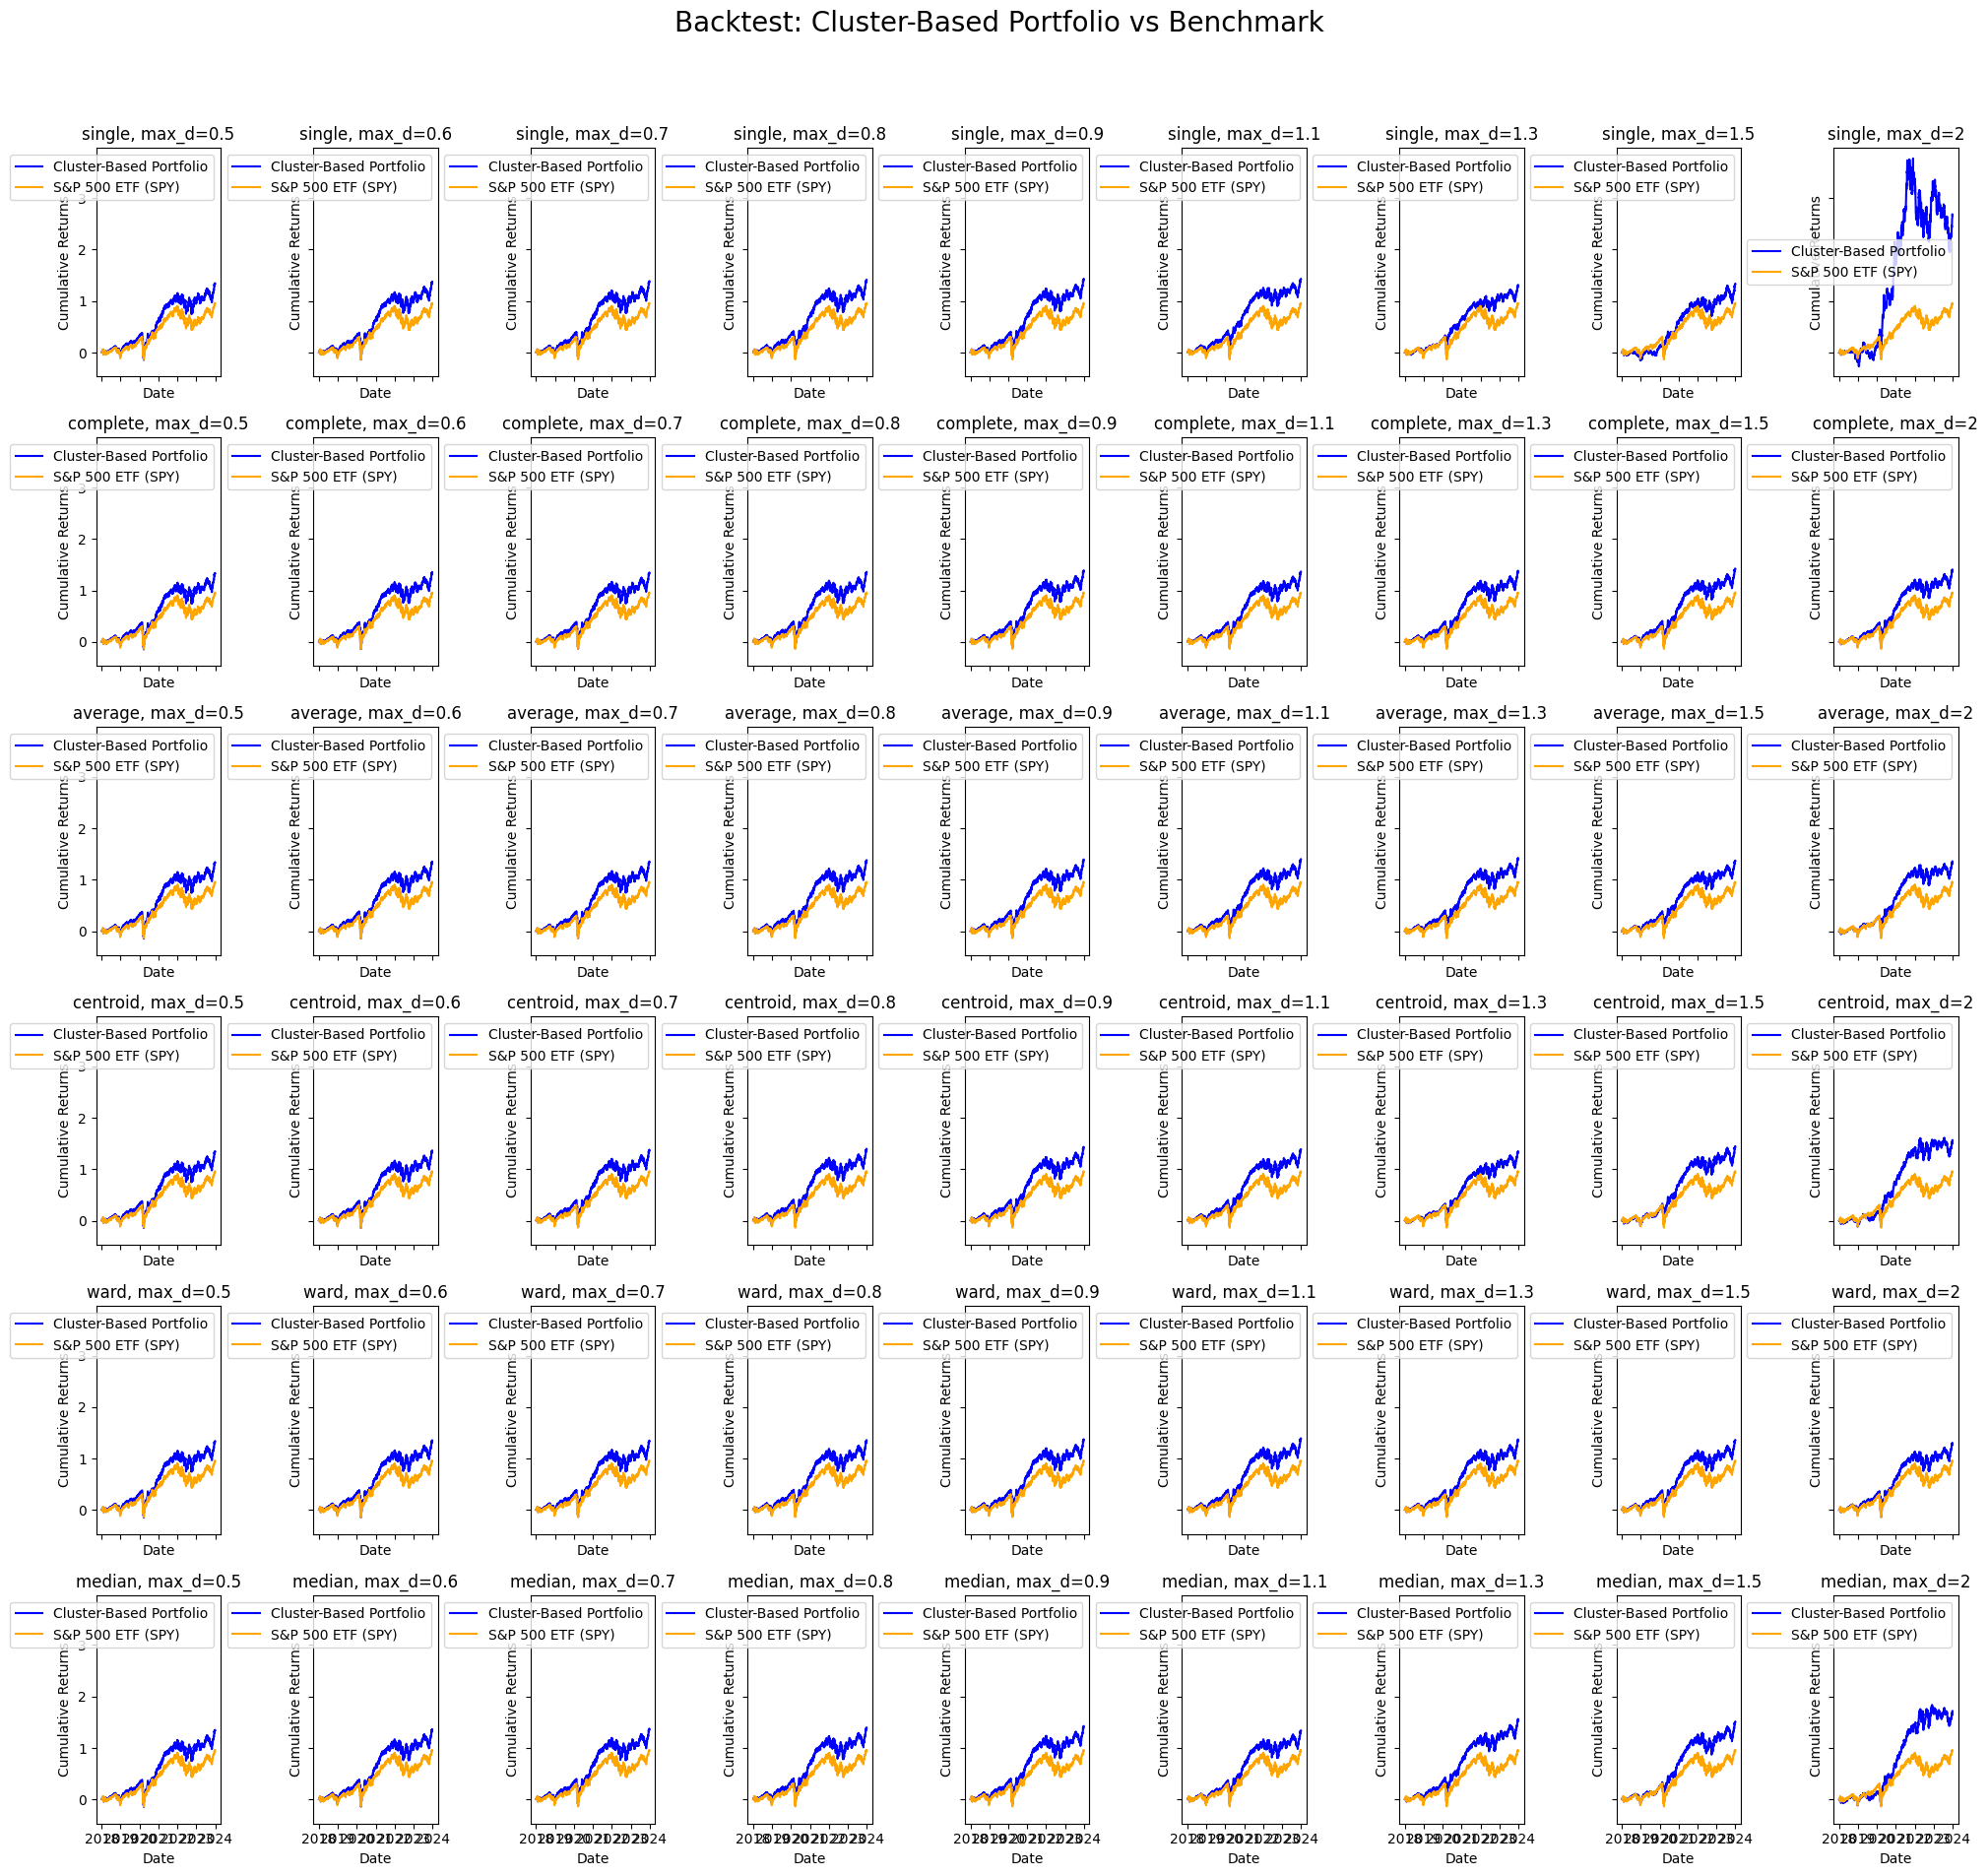

In [25]:
# Prepare subplots
fig, axes = plt.subplots(len(methods), len(max_d_values), figsize=(20, 20), sharex=True, sharey=True)
fig.suptitle("Backtest: Cluster-Based Portfolio vs Benchmark", fontsize=20)

for i, method in enumerate(methods):
    for j, max_d in enumerate(max_d_values):
        distance_matrix = 1 - (R.drop(columns = "Ticker")).abs()
        condensed_distance_matrix = pdist(distance_matrix)
        linkage_matrix = linkage(condensed_distance_matrix, method=method)
        clusters = fcluster(linkage_matrix, max_d, criterion='distance')

        # Calculate metrics
        silhouette_avg = silhouette_score(distance_matrix, clusters, metric='precomputed')
        c, _ = cophenet(linkage_matrix, condensed_distance_matrix)
        ch_score = calinski_harabasz_score(normalized_returns.T, clusters)
        db_score = davies_bouldin_score(normalized_returns.T, clusters)

        # Append to results
        result = pd.DataFrame({
            'Method': [method],
            'Max_d': [max_d],
            'Silhouette Score': [silhouette_avg],
            'Cophenetic Correlation': [c],
            'Calinski-Harabasz Score': [ch_score],
            'Davies-Bouldin Score': [db_score]
        })
        results = pd.concat([results, result], ignore_index=True)

        # Cluster-based portfolio
        cluster_returns = []
        unique_clusters = np.unique(clusters)
        for cluster in unique_clusters:
            cluster_stocks = [dataset.columns[k] for k in range(len(dataset.columns)) if clusters[k] == cluster]
            cluster_data = returns[cluster_stocks].mean(axis=1)
            cluster_returns.append(cluster_data)

        # Combine cluster returns into a portfolio
        combined_returns = pd.concat(cluster_returns, axis=1).mean(axis=1)
        combined_cum_returns = (1 + combined_returns).cumprod() - 1
        
        benchmark_cum_returns = (1 + benchmark_returns).cumprod() - 1
        # Plot on the respective subplot
        ax = axes[i, j]
        ax.plot(benchmark_cum_returns.reset_index()["Date"], combined_cum_returns, label="Cluster-Based Portfolio", color="blue")
        ax.plot(benchmark_cum_returns.reset_index()["Date"], benchmark_cum_returns.reset_index()["SPY"], label="S&P 500 ETF (SPY)", color="orange")
        ax.set_title(f"{method}, max_d={max_d}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Cumulative Returns")
        ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [26]:
max_cols = ["Silhouette Score", "Cophenetic Correlation", "Calinski-Harabasz Score"]
min_cols = ["Davies-Bouldin Score"]



# Custom function for styling
def highlight_extremes(val, col_name):
    max_color = "background-color: green"
    min_color = "background-color: blue"
    
    if col_name in max_cols and val == normalized_results[col_name].max():
        return max_color
    elif col_name in min_cols and val == normalized_results[col_name].min():
        return min_color
    return ""

# Identify optimal values after normalization
max_silhouette = results["Silhouette Score"].max()
max_cophenetic = results["Cophenetic Correlation"].max()
max_calinski = results["Calinski-Harabasz Score"].max()
min_davies_bouldin = results["Davies-Bouldin Score"].min()

# Filter rows where at least one metric is optimal
optimal_results = results[
    (results["Silhouette Score"] == max_silhouette) |
    (results["Cophenetic Correlation"] == max_cophenetic) |
    (results["Calinski-Harabasz Score"] == max_calinski) |
    (results["Davies-Bouldin Score"] == min_davies_bouldin)
]

normalized_results = optimal_results.copy()
for col in max_cols:
    normalized_results[col] = results[col] / results[col].max()

for col in min_cols:
    normalized_results[col] = results[col].min() / results[col]  # Invert min-based scores for consistency
# Apply styling
styled_results = normalized_results.style.apply(
    lambda x: [highlight_extremes(v, x.name) for v in x], axis=0
)

styled_results

,Method,Max_d,Silhouette Score,Cophenetic Correlation,Calinski-Harabasz Score,Davies-Bouldin Score
8,single,2.000000,1.000000,0.793699,0.220479,0.241735
9,complete,0.500000,0.134742,0.954402,0.696255,1.000000
18,average,0.500000,0.148184,1.000000,0.699278,0.999335
19,average,0.600000,0.197773,1.000000,0.584466,0.803184
20,average,0.700000,0.257193,1.000000,0.489074,0.666507
21,average,0.800000,0.276729,1.000000,0.426270,0.521447
22,average,0.900000,0.327181,1.000000,0.402896,0.453378
23,average,1.100000,0.237715,1.000000,0.364620,0.323804
24,average,1.300000,0.100305,1.000000,0.369368,0.225962
25,average,1.500000,0.052568,1.000000,0.439781,0.166201


In [30]:
normalized_results["final"] = normalized_results["Silhouette Score"]+normalized_results["Calinski-Harabasz Score"]+normalized_results["Cophenetic Correlation"]-normalized_results["Davies-Bouldin Score"]
normalized_results                

,Method,Max_d,Silhouette Score,Cophenetic Correlation,Calinski-Harabasz Score,Davies-Bouldin Score,final
8,single,2.0,1.000000,0.793699,0.220479,0.241735,1.772443
9,complete,0.5,0.134742,0.954402,0.696255,1.000000,0.785400
18,average,0.5,0.148184,1.000000,0.699278,0.999335,0.848126
19,average,0.6,0.197773,1.000000,0.584466,0.803184,0.979055
20,average,0.7,0.257193,1.000000,0.489074,0.666507,1.079760
21,average,0.8,0.276729,1.000000,0.426270,0.521447,1.181552
22,average,0.9,0.327181,1.000000,0.402896,0.453378,1.276698
23,average,1.1,0.237715,1.000000,0.364620,0.323804,1.278531
24,average,1.3,0.100305,1.000000,0.369368,0.225962,1.243712
25,average,1.5,0.052568,1.000000,0.439781,0.166201,1.326148


In [33]:
distance_matrix = 1 - (R.drop(columns = "Ticker")).abs()
condensed_distance_matrix = pdist(distance_matrix)
linkage_matrix = linkage(condensed_distance_matrix, method="centroid")
clusters = fcluster(linkage_matrix, 2.0, criterion='distance')

In [34]:
import importlib
import analysis.data.dataframe_creation as dataframe_creation
importlib.reload(dataframe_creation)
from analysis.data.dataframe_creation import pipeline
sd = "2018-01-01"
ed = "2024-01-01"
dataset = pipeline(sd, ed)

[*********************100%***********************]  1 of 1 completed


Total number of tickers 502


[*********************100%***********************]  502 of 502 completed

6 Failed downloads:
['GEV', 'SOLV', 'SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1704085200")')
['BF.B', 'ETN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')



Null values: False
NaN values: False

Creating features
The dataset has 484 assets
The dataset has 16 predictors:
Ticker
Yavg_return
Yavg_volatility
beta
mkt_corr
Davg_span
Davg_volume
D_eSkewness
D_eVaR
D_eCVaR
D_eCurtosis
Sharpe_ratio
totalEsg
environmentScore
socialScore
governanceScore
industry


Dataset creation finished



In [42]:
final_dataframe = dataset[dataset["Ticker"].isin(returns.columns)]
final_dataframe["Sector"] = clusters

cluster_profile = final_dataframe.groupby("Sector").mean(numeric_only=True)

# Add counts for the number of stocks in each cluster
cluster_profile["Count"] = final_dataframe.groupby("Sector")["Ticker"].count().values
cluster_profile["Sharpe_ratio"] = (cluster_profile["Yavg_return"]-0.02)/cluster_profile["Yavg_volatility"]

max_cols = ["beta", "D_eSkewness", "Yavg_return", "Sharpe_ratio", "Davg_volume"]
min_cols = ["beta", "Davg_span", "D_eCurtosis", "Yavg_volatility", "D_eVaR", "D_eCVaR", 
            "totalEsg", "environmentScore", "socialScore", "governanceScore"]

# Custom function for styling
def highlight_extremes(val, col_name):
    max_color = "background-color: green"
    min_color = "background-color: blue"
    
    if col_name in max_cols and val == cluster_profile[col_name].max():
        return max_color
    elif col_name in min_cols and val == cluster_profile[col_name].min():
        return min_color
    return ""

cluster_profile.style.apply(lambda x: [highlight_extremes(v, x.name) for v in x], axis=0)

,Yavg_return,Yavg_volatility,beta,mkt_corr,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,Count
Sector,,,,,,,,,,,,,,,,
1,0.104380,0.265850,0.784160,0.602789,1.509613,3279965.345182,-0.482046,-0.000532,-0.000879,16.018688,0.317398,18.786667,7.625833,6.649167,4.511250,25
2,0.094680,0.253707,0.636074,0.509348,2.198068,3232901.009000,-0.132545,-0.000382,-0.000622,14.539911,0.294356,21.706452,9.057419,8.130645,4.518387,31
3,0.149766,0.462399,1.206539,0.532932,2.167335,6740345.350591,-0.254154,-0.001071,-0.001755,14.405545,0.280637,25.857826,10.667826,9.372826,5.816522,47
4,0.190735,0.329993,1.019022,0.627221,4.529312,8590066.783408,-0.138778,-0.000423,-0.000652,9.473125,0.517390,18.525449,4.312584,8.995112,5.217978,179
5,0.146127,0.343596,1.132255,0.675984,2.718523,4231908.770084,-0.020313,-0.000684,-0.001080,12.248356,0.367078,20.490962,5.168397,8.997308,6.324872,157
6,0.114787,0.538512,0.680643,0.251088,0.897324,11595471.669980,0.906106,-0.002535,-0.005701,34.869001,0.176017,25.950000,9.085000,13.400000,3.465000,2
7,0.061806,0.246231,0.356438,0.297050,1.344300,2511277.400845,-0.250261,-0.000489,-0.000823,10.370765,0.169783,25.707500,10.370000,11.283750,4.056250,8
8,0.146323,0.300149,0.319708,0.217173,0.816380,8118916.103380,0.009273,-0.000902,-0.001412,6.568472,0.420869,22.800000,7.040000,10.850000,4.910000,1
9,0.148467,0.481176,0.839487,0.361134,0.817862,7133655.361166,0.565913,-0.002303,-0.003240,6.437457,0.266986,32.220000,17.960000,8.460000,5.800000,2


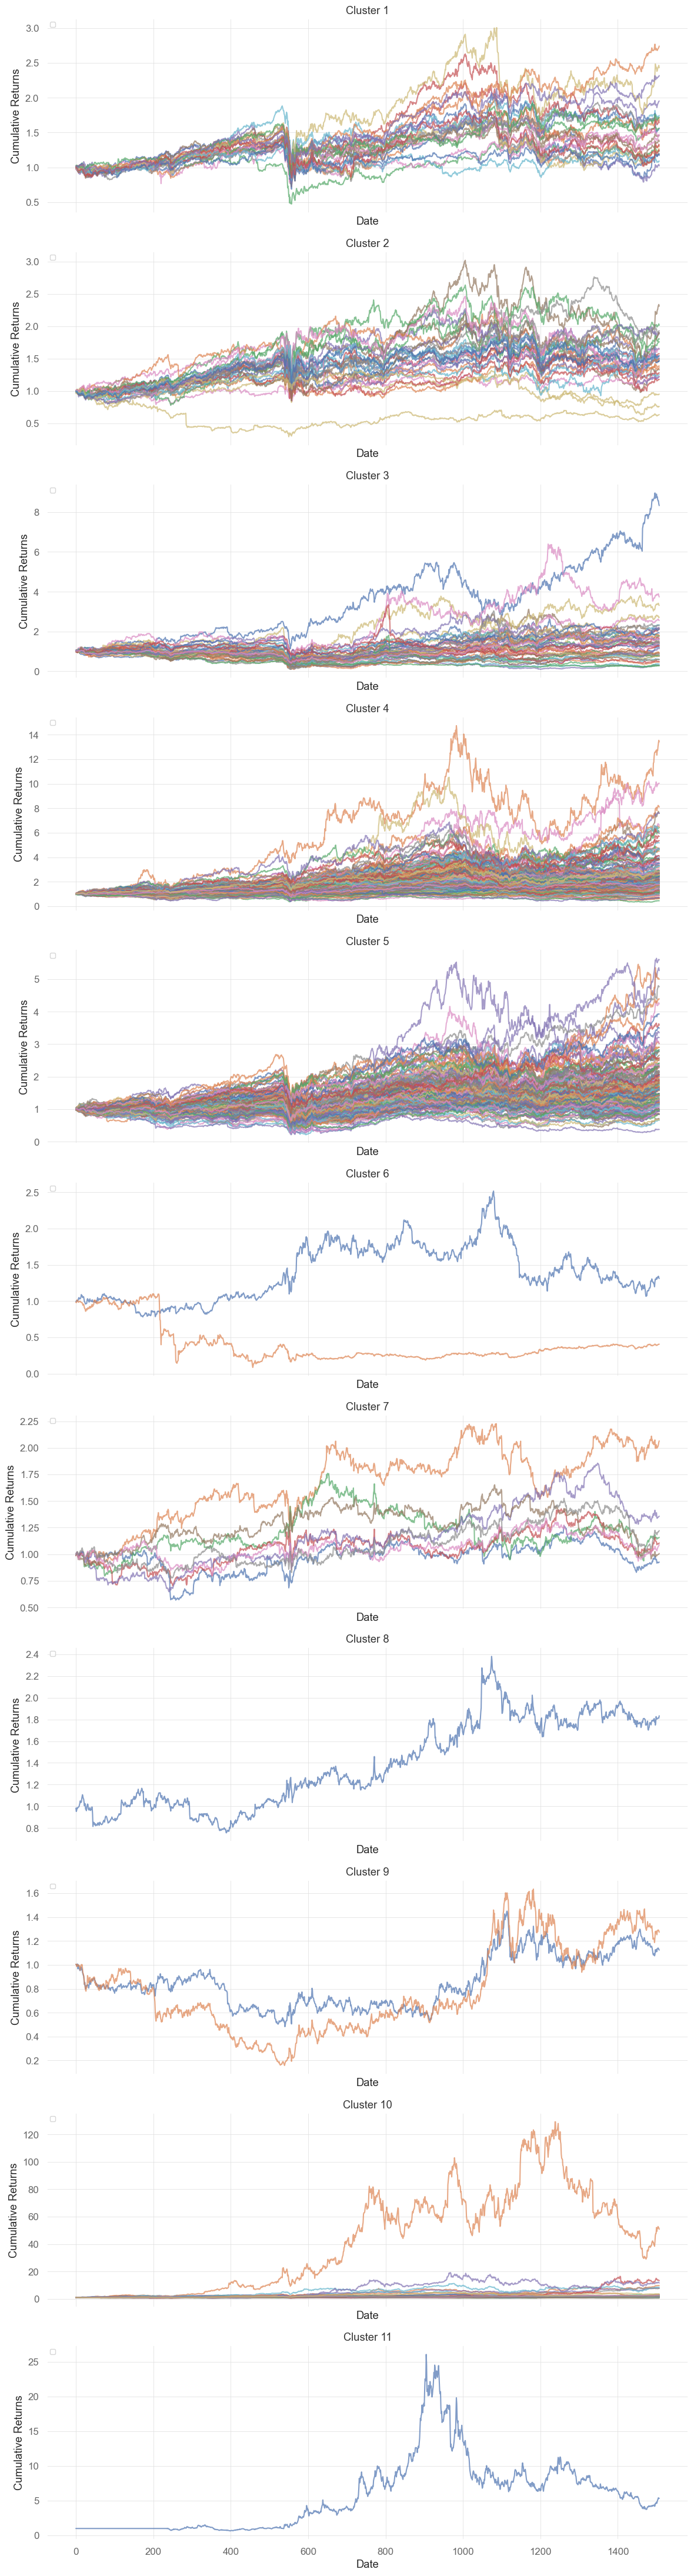

In [50]:
clusters_df = pd.DataFrame({'Ticker': returns.columns, 'Cluster': clusters})

# Identify unique clusters
unique_clusters = np.unique(clusters)

num_clusters = len(unique_clusters)

# Prepare subplots
fig, axes = plt.subplots(num_clusters, 1, figsize=(12, 4 * num_clusters), sharex=True)

if num_clusters == 1:  # Ensure axes is iterable for a single cluster case
    axes = [axes]

# Plot return evolution for each cluster
for i, cluster in enumerate(unique_clusters):
    ax = axes[i]
    
    # Select tickers belonging to this cluster
    cluster_tickers = clusters_df[clusters_df["Cluster"] == cluster]["Ticker"].values

    # Compute cumulative returns for each stock
    for ticker in cluster_tickers:
        cumulative_returns = (1 + returns[ticker]).cumprod()
        ax.plot(returns.index, cumulative_returns, alpha=0.7)

    ax.set_title(f"Cluster {cluster}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Returns")
    ax.legend(fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()